# Grover 

The purpose of this notebook is to briefly demonstrate the programming and execution of a simple Grover algorithm in the QLM.

## Grover's algorithm

Grover's algorithm rely on a two main ingredients:
- a diffusion operator $\mathcal{D} = 2 |s\rangle\langle s| - I$, where $|s\rangle = \frac{1}{\sqrt{2^n}}\sum |i\rangle$
- and an oracle "marking" some basis states by flipping their phases: $O_f = \sum_i (-1)^{f(i)}|i\rangle\langle i|$ for some boolean predicate $f$


### Diffusion operator

Lets first start by programming a piece of pyAQASM code that will generate a diffusion operator.
$\mathcal{D}$ can be obtained by:
- performing a basis change from the computation basis to the diagonal basis (i.e a cascade of H gates)
- performing a collectiong of bit flips in order to send the $|0^n\rangle$ state onto $|1^n\rangle$
- performing a "global" controlled-Z gate in order to flip the phase of $|0^n\rangle$
- undoing the bit flips
- undoing the basis change


This can be easily expressed in pyAQASM as follows:

In [1]:
#directement copié du tuto GROVER
from qat.lang.AQASM import QRoutine, Z, H, X, CNOT,Program
from qat.lang.AQASM.misc import build_gate

@build_gate("D", [int], arity=lambda n: n)
def diffusion(nbqbits):
    rout = QRoutine()
    wires = rout.new_wires(nbqbits)
    with rout.compute():
        for wire in wires:
            H(wire)
            X(wire)
    Z.ctrl(nbqbits - 1)(wires)
    rout.uncompute()
    return rout

example = diffusion(4)
example.display()


Nous avons maintenant une fonction qui produit des opérateurs de diffusion de la bonne taille. De plus, cette fonction est enveloppée dans une "boîte" appelée "D" pour la diffusion (c'est principalement à des fins de visualisation)

Construction d'un exemple plus simple que les graphes colorés du tuto

On prend un problème plus simple  que celui du tuto. Le problème proposé dans l'exposé de Cindy : On a $n$ cases qui contiennent des pommes à par la case $n_0$  qui contient une orange. Il faut trouver $n_0$. 

[Livre Quantum page 127]

Nous modélisons la recherche dans une liste non ordonnée à l’aide d’une fonction mathématique. Soit $N$ un entier fixé et soit $k_0$ un entier avec $0\leq k_0 \leq N-1$. Définissons alors la fonction $f : \{0,1,\ldots,N −1\} \rightarrow \{0,1\}$ par
$f (k_0) = 1$ et $f (k) = 0$ pour tout $k\neq k_0$. Problème. Étant donnée une telle fonction $f$ , trouver la valeur $k_0$ telle que $f (k_0) = 1$.

ALGORITHME DE GROVER Il s’agit donc de trouver l’antécédent de 1 par f .
Ca correspond à identifier $f : (Z/2Z)^{2N}\rightarrow Z/2Z$ qui envoie 
$|\underline{n_0}>$ sur 1 et tous les autres n-qubits sur 0.


On se place dans le cas où $N$ est une puissance de 2 $N=2^n$.  $k_0$ un entier avec $0\leq k \leq N-1$ s'écrit en binaire $\underline k$ sur n bits. Ainsi $|\underline k>$ pour $0\leq k \leq N-1$  désigne les n-qubits de la base canonique : $$
|\underline{0}= |0.0 \ldots 0〉,~ |\underline{1}= |0.0 \ldots 1〉,\ldots, ,~ |\underline{2^n-1}= |1.1 \ldots 1〉.$$


Dans la cellule suivante on a programmé l'oracle pour la  fonction correspondant à $n_0=2^n-1$. C'est la plus simple : il n'y a rien à faire à part implémenter $y\oplus f(x)$ par une X contrôlée par tous les premiers qbits.
Vérifiez que vous comprenez les résultats puis changez l'oracle pour retrouver la fonction correspondant à $n_0=2^{n-1}$ par exemple.

In [2]:

@build_gate("O", [int], arity=lambda n: n)
def oracle(nbqbits):
        # on programme le cas  |n0_>=|1111...111>
    # attention nbqbits=nqbits+1 le dernier qbits est utilisé pour y+f(x) 
    rout = QRoutine()
    wires = rout.new_wires(nbqbits)
    X.ctrl(nbqbits - 1)(wires)  #y+f(x) 
    return rout
example = oracle(4)
example.display()



In [3]:
#vérification de l'oracle
from qat.qpus import get_default_qpu
qpu = get_default_qpu()
prog = Program()
m=4
data = prog.qalloc(m)
# On prépare les m-1 premiers qbits à |k0_>==|0010000>  pour que l'oracle le reconnaisse
prog.apply(X,data[2])
####
prog.apply(X,data[m-1])
prog.apply(H,data[m-1])
oracle(m)(data)
circuit = prog.to_circ(box_routines=True)
circuit.display()
result = qpu.submit(circuit.to_job())
print("on vérifie que le dernier qbit=|-> si |k_> est différent de |k0_> et -|-> si |k_> == |k0_> ")
for s in result:
    print(s.state, "dernier qbit=|",1*s.state[m-1],">",s.amplitude)
    print(s.state,s.amplitude)


on vérifie que le dernier qbit=|-> si |k_> est différent de |k0_> et -|-> si |k_> == |k0_> 
|0010> dernier qbit=| 0 > (0.7071067811865475+0j)
|0010> (0.7071067811865475+0j)
|0011> dernier qbit=| 1 > (-0.7071067811865475+0j)
|0011> (-0.7071067811865475+0j)


In [4]:
import numpy as np
prog = Program()
m=4
data = prog.qalloc(m)
prog.reset(data)
sol = prog.calloc(m)


prog.apply(X,data[m-1])
for i in range(m):
    prog.apply(H,data[i])

ll=int(np.pi*np.sqrt(2**m)/4) # ll est une borne max pour le nombre d'itérations
print(ll)

3


|1110>
|1110> dernier qbit=| 0 > (1+0j)


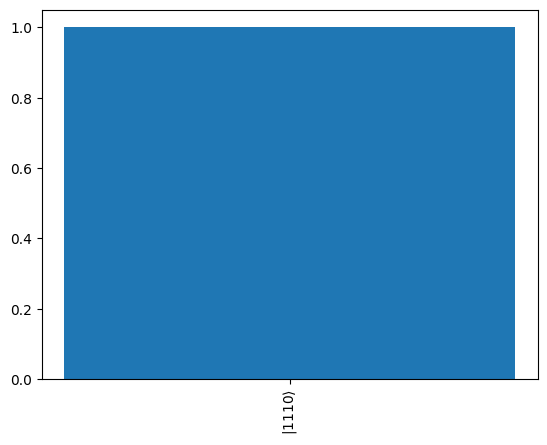

In [5]:
for i in range(2): # 
    oracle(m)(data)
    diffusion(m-1)(data[:m-1])
prog.measure(data, sol)

circuit = prog.to_circ(box_routines=True)
circuit.display()
from qat.qpus import PyLinalg

#result = PyLinalg().submit(circuit.to_job(qubits=[0], nbshots=50))
result = PyLinalg().submit(circuit.to_job( ))
for s in result:
    print(s.state)
    print(s.state, "dernier qbit=|",1*s.state[m-1],">",s.amplitude)
result.plot()

In [ ]:
#passage à l'échelle 
prog = Program()
m=10
data = prog.qalloc(m)
prog.reset(data)
sol = prog.calloc(m)


prog.apply(X,data[m-1])
for i in range(m):
    prog.apply(H,data[i])

ll=int(np.pi*np.sqrt(2**m)/4) # ll est une borne max pour le nombre d'itérations
print("on doit faire au plus ",ll," itérations au lieu de ",2**m,"évaluations de f")

In [ ]:
for i in range(24): # 
    oracle(m)(data)
    diffusion(m-1)(data[:m-1])
prog.measure(data, sol)

circuit = prog.to_circ(box_routines=True)
circuit.display()
from qat.qpus import PyLinalg

result = PyLinalg().submit(circuit.to_job( ))
for s in result:
    print(s.state)
result.plot()